Generating Regional Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


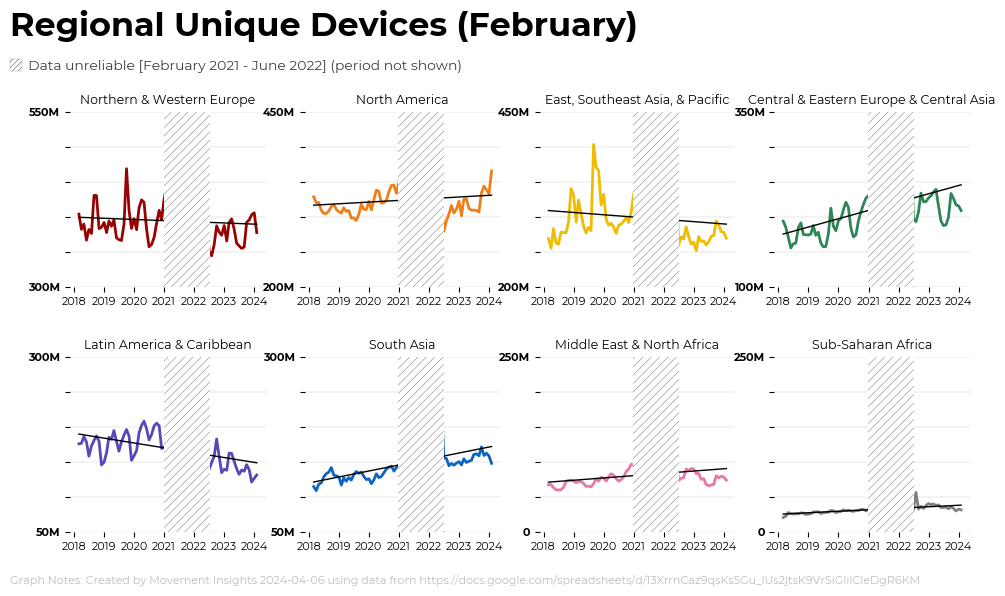

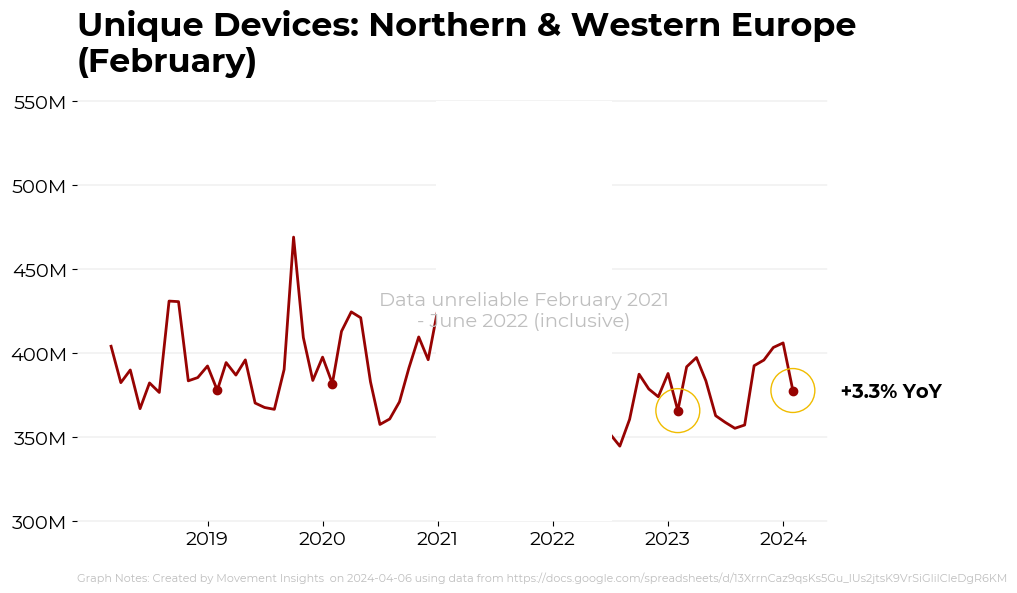

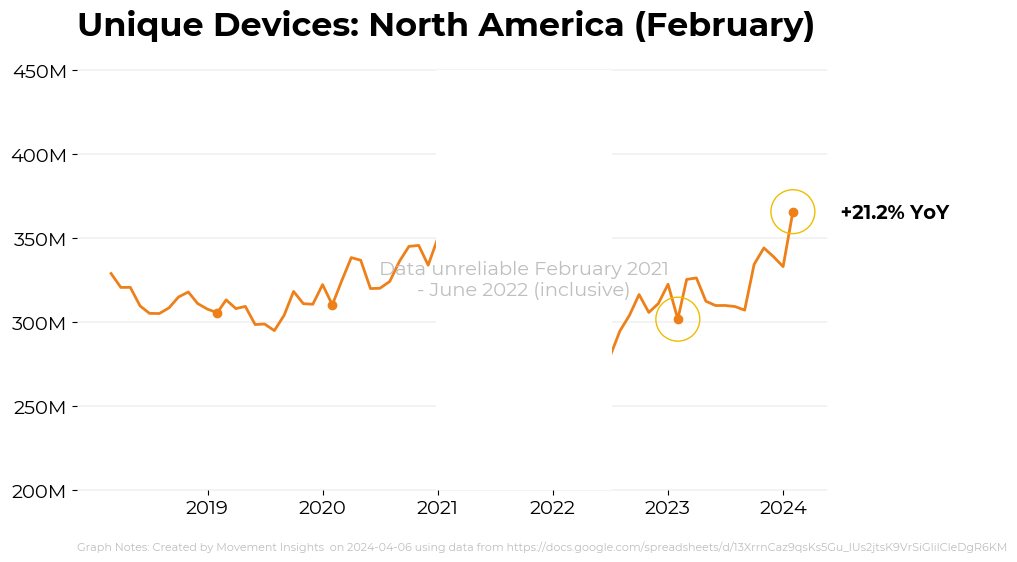

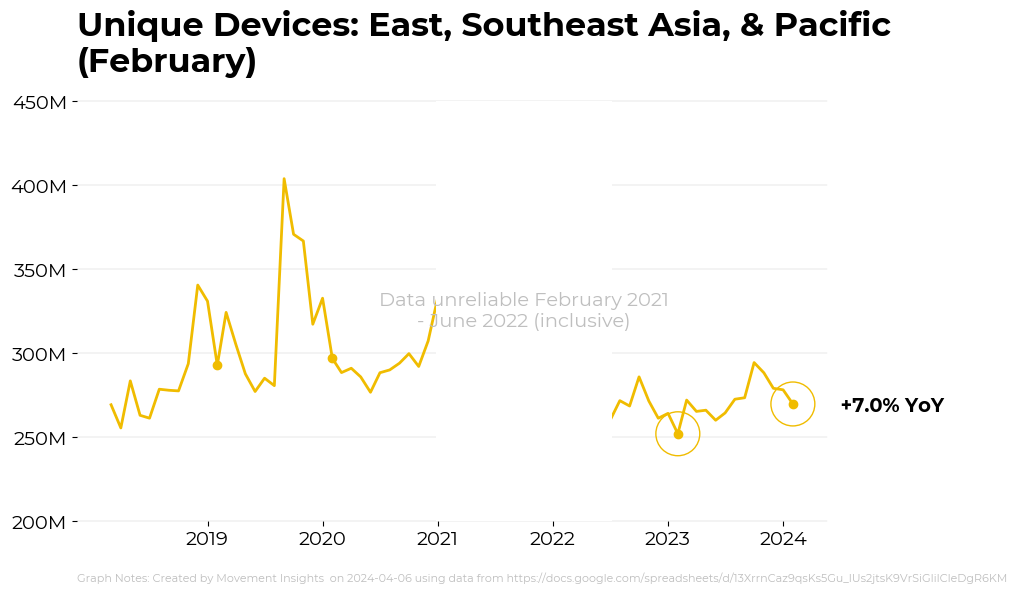

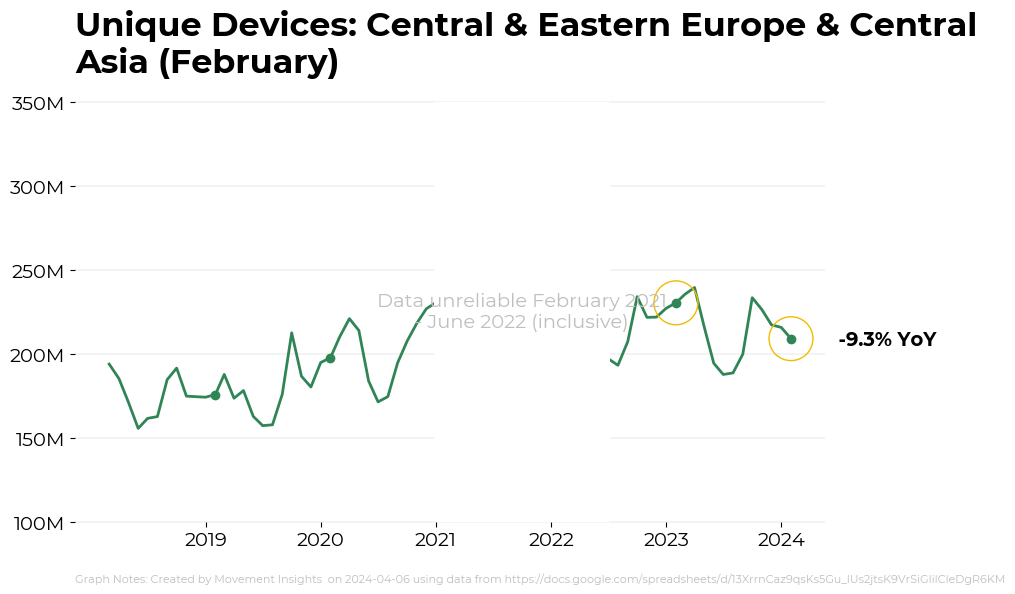

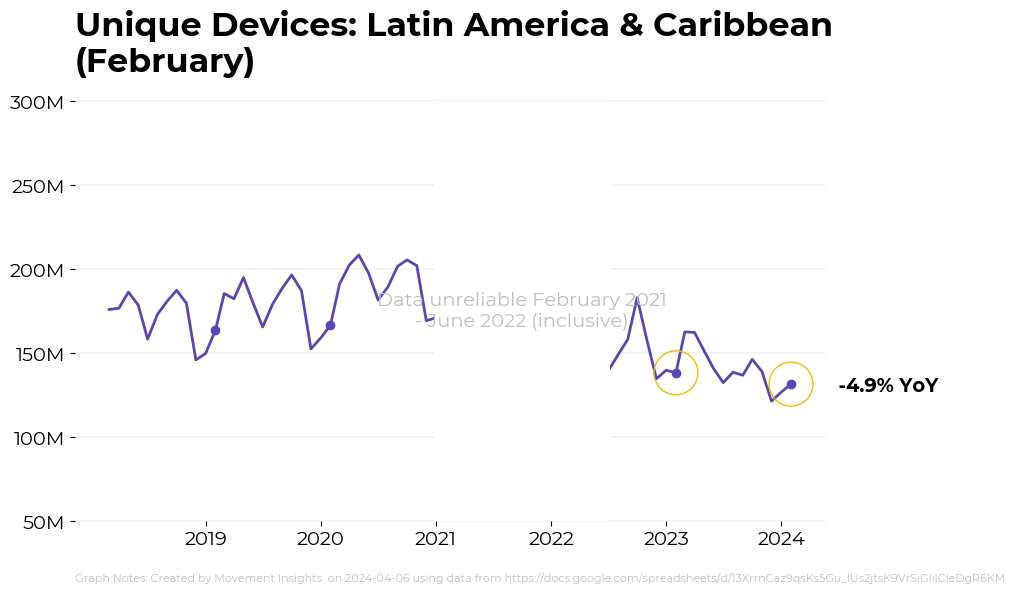

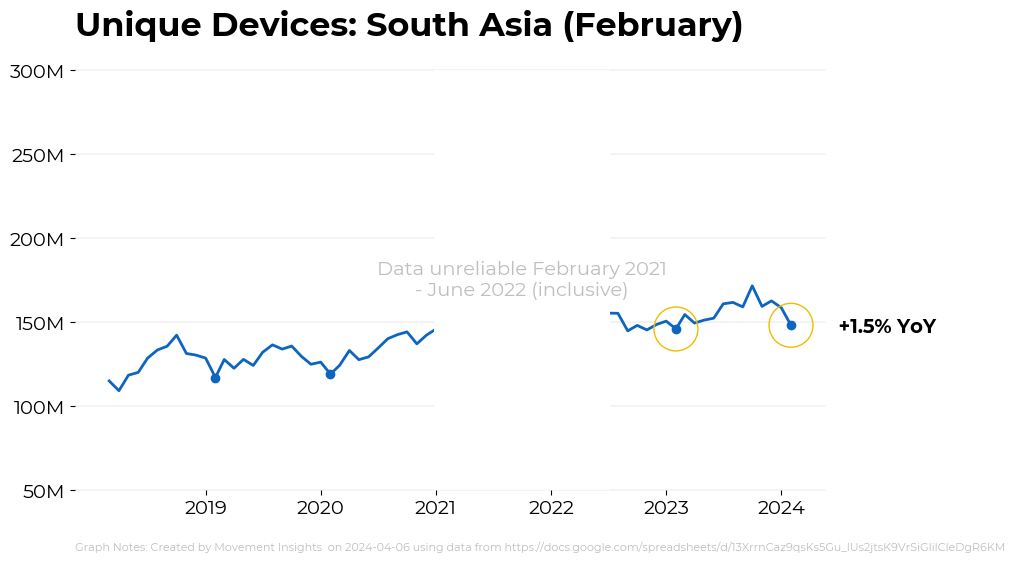

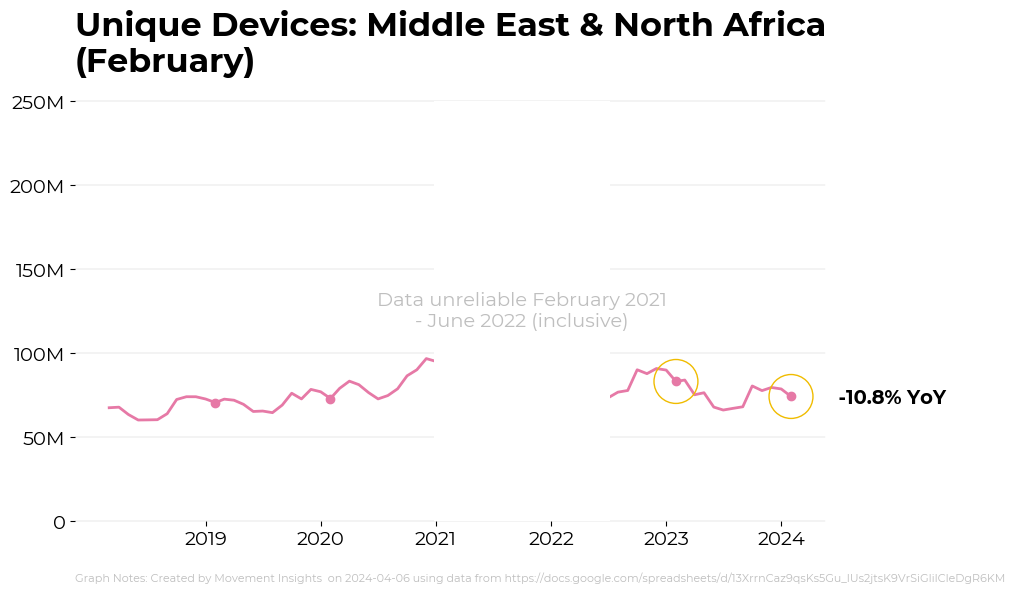

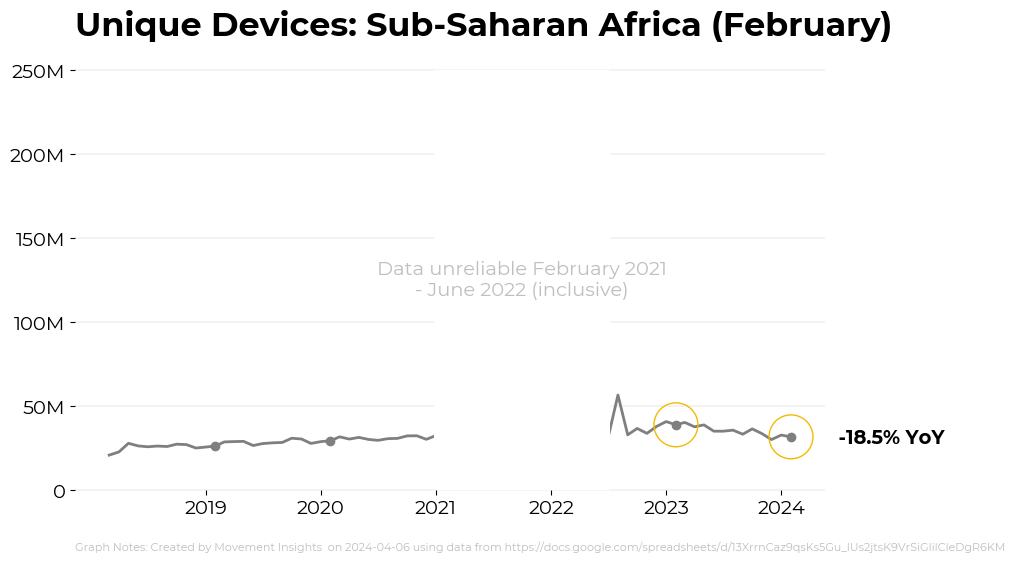

In [1]:
import pandas as pd
from datetime import date, datetime, timedelta
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.ticker as ticker
import numpy as np
import os
from os.path import dirname

import warnings
#local
#from wikicharts import Wikichart, wmf_colors, wmf_regions, split_df_by_col, gen_keys, roll
#jupyter notebook
%run wikicharts.ipynb

def main():
    print("Generating Regional Unique Devices chart...")
    print("Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.")

    warnings.filterwarnings("ignore")

    #---PROMPT FOR INPUT---
    save_file_name_base = "Regional_Unique_Devices"
    #note for labeling the YoY highlight
    yoy_note = " "
    #display or note
    display_flag = True

    #---CLEAN DATA--
    #Data Columns: "month", one column for each region
    df = pd.read_csv(unique_devices_data_path, sep='\t')
    
    #note start and end dates may be different depending on chart_type
    start_date = "2018-03-01"
    end_date = datetime.today()
    block_off_start = datetime.strptime("2021-01-01", '%Y-%m-%d')
    block_off_end = datetime.strptime("2022-07-01", '%Y-%m-%d')
    
    #convert string to datetime
    df['month'] = pd.to_datetime(df['month'])
    
    #truncate data to period of interest
    df = df[df["month"].isin(pd.date_range(start_date, end_date))]
    
    # Rename columns to nicely-formatted region names
    column_names_to_region_names = {
        'central_eastern_europe_central_asia_unique_devices': 'Central & Eastern Europe & Central Asia',
        'east_southeast_asia_pacific_unique_devices': 'East, Southeast Asia, & Pacific',
        'latin_america_caribbean_unique_devices': 'Latin America & Caribbean',
        'middle_east_north_africa_unique_devices': 'Middle East & North Africa',
        'north_america_unique_devices': 'North America',
        'northern_western_europe_unique_devices': 'Northern & Western Europe',
        'south_asia_unique_devices': 'South Asia',
        'subsaharan_africa_unique_devices': 'Sub-Saharan Africa'
    }
    
    df = df.rename(column_names_to_region_names, axis='columns')
    
    # Sort columns by cumulative total, highest on the left
    df = df.set_index('month')
    columns_in_order = df.sum().sort_values(ascending=False).index
    df = df[columns_in_order]

    #create different dfs for each figure
    max_charts_per_figure = 8
    
    # gen_keys expects a list of data frames, with no index
    dfs = [df.reset_index()]
    df = df.reset_index()
    
    # Generate keys that map each region to a different color
    key_colors = [wmf_colors['red'], wmf_colors['orange'], wmf_colors['yellow'], wmf_colors['green'], wmf_colors['purple'], wmf_colors['blue'], wmf_colors['pink'], wmf_colors['black50'], wmf_colors['brightblue'],wmf_colors['red']]
    keys = gen_keys(dfs, key_colors)

    #---MAKE CHART---
    #annotation to explain boxes
    annotation_text = "     Data unreliable [February 2021 - June 2022] (period not shown)" #or use /// instead of rectangle patch
    #make charts
    fig_counter = 0
    total_num_charts = len(df.columns) - 1
    num_figures = ceil(total_num_charts / max_charts_per_figure)
    figures = [None]*num_figures
    #max range across figures
    maxranges = [None]*num_figures 
    num_ticks = [None]*num_figures
    #initialize each figure
    for f in range(num_figures):
        charts_in_figure = len(dfs[f].columns) - 1
        figures[f] = Wikichart(start_date,end_date,dfs[f])
        figures[f].init_plot(width=12,subplotsx=2,subplotsy=4,fignum=f)
        figures[f].plot_subplots_lines('month', keys[f], num_charts=charts_in_figure, subplot_title_size=9)
        figures[f].plot_multi_trendlines('month', keys[f], num_charts=charts_in_figure)
        maxranges[f], num_ticks[f] = figures[f].get_maxyrange()
    #calculate the largest range between the two figures and multiple subplots
    maxrange = max(maxranges)
    maxrange_index = maxranges.index(maxrange)
    maxrange_numticks = num_ticks[maxrange_index]
    #format and display each figure
    for f in range(num_figures):
        plt.figure(f)
        charts_in_figure = len(dfs[f].columns) - 1
        figures[f].standardize_subplotyrange(maxrange, maxrange_numticks, num_charts=charts_in_figure)
        figures[f].block_off_multi(block_off_start,block_off_end)
        figures[f].add_block_legend()
        figures[f].format_subplots(title = 'Regional Unique Devices',
            key = keys[f],
            data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
            tadjust=0.8, badjust=0.1,
            num_charts=charts_in_figure,
            tickfontsize=8)
        figures[f].clean_ylabels_subplots(tickfontsize=8)
        figures[f].top_annotation(annotation_text = annotation_text)
        #save chart but set display to False because plt.show() will show all figures at once
        save_file_name = save_file_name_base + "_0" + str(f) + ".jpeg"
        figures[f].finalize_plot(save_file_name,display=False)
        fig_counter += 1

    #---GENERATE INDIVIDUAL CHARTS---
    individual_charts = [None]*total_num_charts
    columns = list(df.columns)
    columns.remove('month')
    for c in range(len(columns)):
        current_col = columns[c]
        current_df = df[['month', current_col]]
        current_savefile = save_file_name_base + "_" + str(c) + ".jpeg"
        individual_charts[c] = Wikichart(start_date,end_date,current_df)
        individual_charts[c].init_plot(fignum=fig_counter)
        #cycle through key colors
        current_color = key_colors[(c % len(key_colors))]
        individual_charts[c].plot_line('month',current_col,current_color)
        individual_charts[c].plot_monthlyscatter('month',current_col,col =current_color)
        individual_charts[c].plot_yoy_highlight('month',current_col)
        current_yrange = individual_charts[c].get_ytickrange()
        if current_yrange > (maxrange / 8):
            individual_charts[c].standardize_yrange(maxrange, maxrange_numticks)
        individual_charts[c].block_off(block_off_start,block_off_end, rectangle_text="Data unreliable February 2021 - June 2022 (inclusive)")
        individual_charts[c].format(title = f'Unique Devices: {current_col}',
            ybuffer=False,
            data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
            tadjust=0.825,badjust=0.125,
            titlepad=25)
        individual_charts[c].annotate(x='month',
            y=current_col,
            num_annotation=individual_charts[c].calc_yoy(y=current_col,yoy_note=yoy_note))
        individual_charts[c].finalize_plot(current_savefile,display=False)
        fig_counter +=1

if __name__ == "__main__":
    main()